This is for the steps to add given the fact that it is not generalizing well!
- Augmentation
- Unfreezing

In [1]:
# 1. Setup
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 2. Paths
DATA_DIR = "data/PlantVillage"  

In [3]:
# 3. Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

Train the model by incorporating only tomatoes and potatoes in the data

In [4]:
# 4. Filter the data by tomatoes and potatoes

all_classes = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

Necessary_classes = [cls for cls in all_classes if cls.startswith(("Tomato", "Potato"))]

In [5]:
# 5. Load the Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    class_names=Necessary_classes
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    class_names=Necessary_classes
)

Found 18163 files belonging to 13 classes.
Using 14531 files for training.
Found 18163 files belonging to 13 classes.
Using 3632 files for validation.


In [6]:
# 6. Class names - Tomatoes and potatoes only
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Detected classes: {class_names}")

Detected classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [7]:
# 7. Optimize input pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# 8. Data normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([ ## NEW
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Freeze base

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) ## NEW
x = normalization_layer(x)  ## NEW
x = base_model(x, training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', #replaced the sparse_categorical_crossentropy 
    metrics=['accuracy']
)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,261 (9.88 MB)

 Trainable params: 331,277 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# 10. Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 335s 728ms/step - accuracy: 0.6594 - loss: 1.0352 - val_accuracy: 0.8331 - val_loss: 0.5019
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 312s 685ms/step - accuracy: 0.8420 - loss: 0.4587 - val_accuracy: 0.8472 - val_loss: 0.4359
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 312s 686ms/step - accuracy: 0.8730 - loss: 0.3781 - val_accuracy: 0.8354 - val_loss: 0.4976
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 308s 677ms/step - accuracy: 0.8875 - loss: 0.3291 - val_accuracy: 0.8778 - val_loss: 0.3537
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 309s 680ms/step - accuracy: 0.8918 - loss: 0.3050 - val_accuracy: 0.8868 - val_loss: 0.3424
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 307s 676ms/step - accuracy: 0.8986 - loss: 0.2849 - val_accuracy: 0.8629 - val_loss: 0.3960
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 322s 708ms/step - accuracy: 0.9014 - loss: 0.2786 - val_accuracy: 0.8841 - val_loss: 0.3429
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 307s 675ms/step - accuracy: 0.9158 -

In [12]:
model.save("model/tomato&potato_disease_classifier_v2.h5")

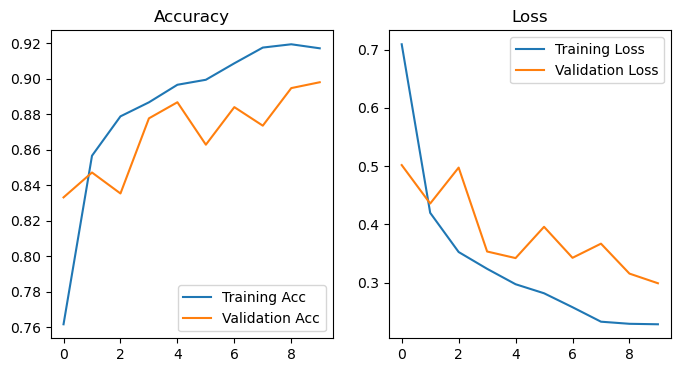

In [13]:
# 11. Plot Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

## Fine Tuning the model

In [14]:
# 10b. Fine-tune the base model
base_model.trainable = True  # unfreeze base model

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 1328s 3s/step - accuracy: 0.5686 - loss: 2.4356 - val_accuracy: 0.8720 - val_loss: 0.4278
Epoch 2/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 1291s 3s/step - accuracy: 0.8297 - loss: 0.5258 - val_accuracy: 0.8309 - val_loss: 0.5789
Epoch 3/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 1290s 3s/step - accuracy: 0.8821 - loss: 0.3560 - val_accuracy: 0.8252 - val_loss: 0.6233
Epoch 4/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 1298s 3s/step - accuracy: 0.9040 - loss: 0.2879 - val_accuracy: 0.8293 - val_loss: 0.5520
Epoch 5/5
455/455 ━━━━━━━━━━━━━━━━━━━━ 1293s 3s/step - accuracy: 0.9229 - loss: 0.2258 - val_accuracy: 0.8480 - val_loss: 0.4880


Fine Tune History

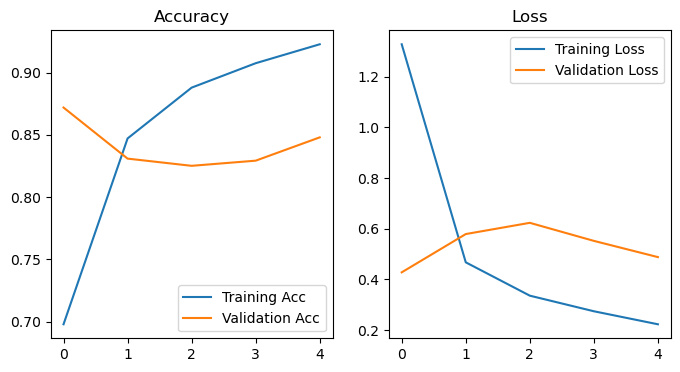

In [16]:
# 11. Plot Accuracy & Loss AGAIN
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [15]:
# 12. Save Model
model.save("model/tomato&potato_disease_classifier_v2_ft.h5")